# Table of Contents

 - [Imports](#Imports)
 - [Read Data](#Read-Data)
 - [Feature Selection](#Feature-Selection)
 - [Evaluation Functions](#Evaluation-Functions)
 - [Preprocessing](#Preprocessing)
 - [Basic Models](#Basic-Models)
 - [Hyperparameter Tuned](#Hyperparameter-Tuned)

# Imports

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler

from pandas.io import sql

from scipy.stats.contingency import expected_freq

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, 
                                plot_roc_curve, roc_auc_score, precision_score, 
                                f1_score, recall_score, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Read Data

In [2]:
connection = sqlite3.connect('./dataset/TEDS_D_2019.db')

In [3]:
sql_query = """
SELECT *
from discharge
"""
original_d = sql.read_sql(sql_query, con = connection)

In [4]:
original_d

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2019,20191553576,2,-9,4,1,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,1
1,2019,20191465214,2,-9,3,1,7,-9,35,1,...,0,0,0,0,0,0,9,4,0,3
2,2019,20191443889,2,-9,2,1,7,-9,35,1,...,0,0,0,0,0,0,9,4,0,3
3,2019,20191409377,2,-9,3,1,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,3
4,2019,20191479567,2,-9,3,3,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722498,2019,20191743528,56,-9,4,2,7,-9,33,1,...,0,0,0,0,0,0,8,4,0,1
1722499,2019,20191666713,56,-9,3,3,7,1,13,7,...,0,0,0,0,0,0,8,4,0,2
1722500,2019,20191405666,56,-9,2,1,6,-9,33,1,...,0,0,0,0,0,0,8,4,0,2
1722501,2019,20191697509,56,-9,1,1,7,3,14,7,...,0,0,0,0,0,0,8,4,0,3


In [5]:
original_d['REASON'] = [1 if x == 1 else 0 for x in original_d['REASON']]

In [6]:
original_d = original_d[~original_d['SUB1'].isin([-9,1])]

In [7]:
original_d.shape

(1590685, 76)

In [8]:
original_d = original_d.replace(to_replace= -9, value= np.nan)

In [9]:
sql_query = """
SELECT d.CASEID, s.states, e.id AS edu_cat, e.education, m.marital_status, ser.service, crim.crim_ref, los.id AS los_cat, los.len_stay, 
        r.ref_source, p.id AS prior_cat, p.treat_ep, a.id AS arrest_cat, a.num_arrest, emp.empl_status, yn.yn_response AS MATS, yn1.yn_response AS co_ment_sub,
        yn2.yn_response AS pregnant, g.gender, yn3.yn_response AS veteran, h.housing, dwait.d_wait, serd.service AS service_dis,
        rea.reason, emp2.empl_status AS empl_status_D, a2.num_arrest AS num_arrest_D, diag.diagnosis, age.age_range, race.race,
        eth.ethnicity, nil.nil_status, nil2.nil_status AS nil_status_D, i.p_income, sub.substance AS substance_1,
        sub2.substance AS substance_2, sub3.substance AS substance_3, subd.substance AS substance_1d,
        subd2.substance AS substance_2d, subd3.substance AS substance_3d, route.sub_route, route2.sub_route AS route2, 
        route3.sub_route AS route3, f.freq, f2.freq AS freq2, f3.freq AS freq3, fd.freq AS freqd, 
        fd2.freq AS freqd2, fd3.freq AS freqd3, afu.id AS afu_cat, afu.age_first_use AS afu, afu2.age_first_use AS afu2, afu3.age_first_use AS afu3,
        ins.insurance, pay.pay_source, sh.self_attend, sh.self_attend AS self_attend_d

FROM discharge as d
INNER JOIN state AS s ON d.STFIPS = s.id
INNER JOIN education AS e ON d.EDUC = e.id
INNER JOIN marital_status AS m ON d.MARSTAT = m.id
INNER JOIN services AS ser ON d.SERVICES = ser.id
INNER JOIN crim_just AS crim ON d.DETCRIM = crim.id
INNER JOIN los ON d.LOS = los.id
INNER JOIN referral as r ON d.PSOURCE = r.id
INNER JOIN prior AS p ON d.NOPRIOR = p.id
INNER JOIN arrest AS a ON d.ARRESTS = a.id
INNER JOIN employ AS emp ON d.EMPLOY = emp.id
INNER JOIN yn ON d.METHUSE = yn.id
INNER JOIN yn AS yn1 ON d.PSYPROB = yn1.id
INNER JOIN yn AS yn2 ON d.PREG = yn2.id
INNER JOIN gender AS g ON d.GENDER = g.id
INNER JOIN yn AS yn3 ON d.VET = yn3.id
INNER JOIN housing AS h ON d.LIVARAG = h.id
INNER JOIN days_wait AS dwait ON d.DAYWAIT = dwait.id
INNER JOIN services AS serd ON d.SERVICES = serd.id
INNER JOIN reason_for_discharge AS rea ON d.REASON = rea.id 
INNER JOIN employ AS emp2 ON d.EMPLOY_D = emp2.id
INNER JOIN housing AS h2 ON d.LIVARAG_d = h2.id
INNER JOIN arrest AS a2 ON d.ARRESTS_D = a2.id
INNER JOIN diagnosis AS diag ON d.DSMCRIT = diag.id
INNER JOIN age_admit AS age ON d.AGE = age.id
INNER JOIN race ON d.RACE = race.id
INNER JOIN ethnicity AS eth ON d.ETHNIC = eth.id
INNER JOIN not_in_labor AS nil ON d.DETNLF = nil.id
INNER JOIN not_in_labor AS nil2 ON d.DETNLF_D = nil2.id
INNER JOIN income AS i ON d.PRIMINC = i.id
INNER JOIN substance AS sub ON d.SUB1 = sub.id
INNER JOIN substance AS sub2 ON d.SUB2 = sub2.id
INNER JOIN substance AS sub3 ON d.SUB3 = sub3.id
INNER JOIN substance AS subd ON d.SUB1_D = subd.id
INNER JOIN substance AS subd2 ON d.SUB2_D = subd2.id
INNER JOIN substance AS subd3 ON d.SUB3_D = subd3.id
INNER JOIN route ON d.ROUTE1 = route.id
INNER JOIN route AS route2 ON d.ROUTE2 = route2.id
INNER JOIN route AS route3 ON d.ROUTE3 = route3.id
INNER JOIN freq AS f ON d.FREQ1 = f.id
INNER JOIN freq AS f2 ON d.FREQ2 = f2.id
INNER JOIN freq AS f3 ON d.FREQ3 = f3.id
INNER JOIN freq AS fd ON d.FREQ1_D = fd.id
INNER JOIN freq AS fd2 ON d.FREQ2_D = fd2.id
INNER JOIN freq AS fd3 ON d.FREQ3_D = fd3.id
INNER JOIN age_first_use AS afu ON d.FRSTUSE1 = afu.id
INNER JOIN age_first_use AS afu2 ON d.FRSTUSE2 = afu2.id
INNER JOIN age_first_use AS afu3 ON d.FRSTUSE3 = afu3.id
INNER JOIN insurance AS ins ON d.HLTHINS = ins.id
INNER JOIN payment AS pay ON d.PRIMPAY = pay.id
INNER JOIN self_help AS sh ON d.FREQ_ATND_SELF_HELP = sh.id
INNER JOIN self_help AS shd ON d.FREQ_ATND_SELF_HELP_D = shd.id
"""

discharge_full = sql.read_sql(sql_query, con = connection)
discharge_full

,CASEID,states,edu_cat,education,marital_status,service,crim_ref,los_cat,len_stay,ref_source,...,freqd2,freqd3,afu_cat,afu,afu2,afu3,insurance,pay_source,self_attend,self_attend_d
0,20191553576,Alaska,4,"1-3 years of college, university, or vocationa...",Never married,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,37,More than a year,Individual (includes self-referral),...,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,5,21-24 years,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,"Medicare, other (e.g. TRICARE, CHAMPUS)",Other,No attendance,No attendance
1,20191465214,Alaska,3,Grade 12 (or GED),Never married,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,35,121 to 180 days,Individual (includes self-referral),...,Some use,Missing/unknown/not collected/invalid,3,15-17 years,15-17 years,Missing/unknown/not collected/invalid,"Medicare, other (e.g. TRICARE, CHAMPUS)",Other,No attendance,No attendance
2,20191443889,Alaska,2,Grades 9 to 11,Never married,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,35,121 to 180 days,Individual (includes self-referral),...,Some use,Missing/unknown/not collected/invalid,2,12-14 years,12-14 years,Missing/unknown/not collected/invalid,Medicaid,Medicaid,No attendance,No attendance
3,20191409377,Alaska,3,Grade 12 (or GED),Never married,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,37,More than a year,Individual (includes self-referral),...,Daily use,No use in the past month,3,15-17 years,21-24 years,15-17 years,"Medicare, other (e.g. TRICARE, CHAMPUS)",Other,8-30 times in the past month,8-30 times in the past month
4,20191479567,Alaska,3,Grade 12 (or GED),Separated,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,37,More than a year,Individual (includes self-referral),...,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,7,30 years and over,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,"Medicare, other (e.g. TRICARE, CHAMPUS)",Other,No attendance,No attendance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722498,20191743528,Wyoming,4,"1-3 years of college, university, or vocationa...",Now married,"Ambulatory, non-intensive outpatient",Missing/unknown/not collected/invalid,33,61 to 90 days,Individual (includes self-referral),...,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,3,15-17 years,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,"Private insurance, Blue Cross/Blue Shield, HMO","Private insurance (Blue Cross/Blue Shield, oth...",No attendance,No attendance
1722499,20191666713,Wyoming,3,Grade 12 (or GED),Separated,"Ambulatory, non-intensive outpatient",State/federal court,13,13,Court/criminal justice referral/DUI/DWI,...,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,4,18-20 years,Missing/unknown/not collected/invalid,Missing/unknown/not collected/invalid,Medicaid,Medicaid,No attendance,No attendance
1722500,20191405666,Wyoming,2,Grades 9 to 11,Never married,"Ambulatory, intensive outpatient",Missing/unknown/not collected/invalid,33,61 to 90 days,Individual (includes self-referral),...,Some use,Missing/unknown/not collected/invalid,2,12-14 years,11 years and under,Missing/unknown/not collected/invalid,None,Other,No attendance,No attendance
1722501,20191697509,Wyoming,1,"Less than one school grade, no schooling, nurs...",Never married,"Ambulatory, non-intensive outpatient",Probation/parole,14,14,Court/criminal justice referral/DUI/DWI,...,Some use,No use in the past month,3,15-17 years,15-17 years,15-17 years,Medicaid,Medicaid,No attendance,No attendance


In [10]:
sql_query = """
SELECT d.CASEID, rs.reported_subst AS alcflg,
        rs2.reported_subst AS cokeflg, rs3.reported_subst AS marflg, rs4.reported_subst AS herflg, rs5.reported_subst AS methflg,
        rs6.reported_subst AS opsynflg, rs7.reported_subst AS pcpflg, rs8.reported_subst AS hallflg, rs9.reported_subst AS mthhamflg,
        rs10.reported_subst AS amphflg, rs11.reported_subst AS stimflg, rs12.reported_subst AS benzflg, rs13.reported_subst AS trnqflg,
        rs14.reported_subst AS barbflg, rs15.reported_subst AS sedhpflg, rs16.reported_subst AS inhflg, rs17.reported_subst AS otcflg,
        rs18.reported_subst AS otherflg, cd.cen_div, reg.region, iv.idu, alc.alc_class
FROM discharge as d
INNER JOIN reported_sub AS rs ON d.ALCFLG = rs.id
INNER JOIN reported_sub AS rs2 ON d.COKEFLG = rs2.id
INNER JOIN reported_sub AS rs3 ON d.MARFLG = rs3.id
INNER JOIN reported_sub AS rs4 ON d.HERFLG = rs4.id
INNER JOIN reported_sub AS rs5 ON d.METHFLG = rs5.id
INNER JOIN reported_sub AS rs6 ON d.OPSYNFLG = rs6.id
INNER JOIN reported_sub AS rs7 ON d.PCPFLG = rs7.id
INNER JOIN reported_sub AS rs8 ON d.HALLFLG = rs8.id
INNER JOIN reported_sub AS rs9 ON d.MTHAMFLG = rs9.id
INNER JOIN reported_sub AS rs10 ON d.AMPHFLG = rs10.id
INNER JOIN reported_sub AS rs11 ON d.STIMFLG = rs11.id
INNER JOIN reported_sub AS rs12 ON d.BENZFLG = rs12.id
INNER JOIN reported_sub AS rs13 ON d.TRNQFLG = rs13.id
INNER JOIN reported_sub AS rs14 ON d.BARBFLG = rs14.id
INNER JOIN reported_sub AS rs15 ON d.SEDHPFLG = rs15.id
INNER JOIN reported_sub AS rs16 ON d.INHFLG = rs16.id
INNER JOIN reported_sub AS rs17 ON d.OTCFLG = rs17.id
INNER JOIN reported_sub AS rs18 ON d.OTHERFLG = rs18.id
INNER JOIN census_division AS cd ON d.DIVISION = cd.id
INNER JOIN region AS reg ON d.REGION = reg.id
INNER JOIN iv_drug AS iv ON d.IDU = iv.id
INNER JOIN alc_drug AS alc ON d.ALCDRUG = alc.id
"""

discharge_full2 = sql.read_sql(sql_query, con = connection)
discharge_full2

,CASEID,alcflg,cokeflg,marflg,herflg,methflg,opsynflg,pcpflg,hallflg,mthhamflg,...,trnqflg,barbflg,sedhpflg,inhflg,otcflg,otherflg,cen_div,region,idu,alc_class
0,20191553576,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Pacific,West,IDU not reported,Alcohol only
1,20191465214,Substance reported,Substance not reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Pacific,West,IDU not reported,Alcohol and other drugs
2,20191443889,Substance reported,Substance not reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Pacific,West,IDU not reported,Alcohol and other drugs
3,20191409377,Substance reported,Substance not reported,Substance reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Pacific,West,IDU not reported,Alcohol and other drugs
4,20191479567,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Pacific,West,IDU not reported,Alcohol only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722498,20191743528,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Mountain,West,IDU not reported,Alcohol only
1722499,20191666713,Substance not reported,Substance not reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Mountain,West,IDU not reported,Other drugs only
1722500,20191405666,Substance not reported,Substance not reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Mountain,West,IDU not reported,Other drugs only
1722501,20191697509,Substance reported,Substance not reported,Substance reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance reported,Substance not reported,...,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Substance not reported,Mountain,West,IDU not reported,Alcohol and other drugs


In [11]:
discharge_complete = discharge_full.merge(discharge_full2)

In [12]:
discharge_complete.shape

(1722503, 78)

In [13]:
# connection.close()

In [14]:
discharge_complete = discharge_complete[~discharge_complete['substance_1'].isin(["Missing/unknown/not collected/invalid", "None"])]

In [15]:
discharge_complete.shape

(1590685, 78)

In [16]:
(1590685/1722503)

0.9234729924998679

## Handling Other Missing Values

In [17]:
discharge_complete.columns

Index(['CASEID', 'states', 'edu_cat', 'education', 'marital_status', 'service',
       'crim_ref', 'los_cat', 'len_stay', 'ref_source', 'prior_cat',
       'treat_ep', 'arrest_cat', 'num_arrest', 'empl_status', 'MATS',
       'co_ment_sub', 'pregnant', 'gender', 'veteran', 'housing', 'd_wait',
       'service_dis', 'reason', 'empl_status_D', 'num_arrest_D', 'diagnosis',
       'age_range', 'race', 'ethnicity', 'nil_status', 'nil_status_D',
       'p_income', 'substance_1', 'substance_2', 'substance_3', 'substance_1d',
       'substance_2d', 'substance_3d', 'sub_route', 'route2', 'route3', 'freq',
       'freq2', 'freq3', 'freqd', 'freqd2', 'freqd3', 'afu_cat', 'afu', 'afu2',
       'afu3', 'insurance', 'pay_source', 'self_attend', 'self_attend_d',
       'alcflg', 'cokeflg', 'marflg', 'herflg', 'methflg', 'opsynflg',
       'pcpflg', 'hallflg', 'mthhamflg', 'amphflg', 'stimflg', 'benzflg',
       'trnqflg', 'barbflg', 'sedhpflg', 'inhflg', 'otcflg', 'otherflg',
       'cen_div', 'regio

In [18]:
discharge_complete.education.value_counts()

Grade 12 (or GED)                                                                       722678
Grades 9 to 11                                                                          314318
1-3 years of college, university, or vocational school                                  299744
4 years of college, university, BA/BS, some postgraduate study, or more                  93200
Less than one school grade, no schooling, nursery school, or kindergarten to Grade 8     86860
Missing/unknown/not collected/invalid                                                    73885
Name: education, dtype: int64

In [19]:
discharge_complete =  discharge_complete.replace(to_replace= 'Missing/unknown/not collected/invalid', value= np.nan)
discharge_complete =  discharge_complete.replace(to_replace= 'Missing/unknown/not collected/invalid/no or deferred diagnosis', value= np.nan)
discharge_complete =  discharge_complete.replace(to_replace= -9, value= np.nan)

## EDA

In [20]:
#Set Up Binary Target Variable
discharge_complete['reason'] = [1 if treatment == "Treatment completed" else 0 for treatment in discharge_complete['reason']]

In [21]:
primary_substance_difference = discharge_complete.loc[discharge_complete['substance_1'] != discharge_complete['substance_1d'],
                                ['substance_1','substance_1d']]

In [22]:
discharge_complete.loc[discharge_complete['nil_status'] != discharge_complete['nil_status_D'],['nil_status','nil_status_D']]

,nil_status,nil_status_D
0,NaN,NaN
1,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN
...,...,...
1722493,NaN,NaN
1722497,Homemaker,NaN
1722498,NaN,NaN
1722500,NaN,NaN


In [23]:
#Check how many rows have differing primary substance at the beginning of treatment and the end
discharge_complete.shape[0] - primary_substance_difference.shape[0]

1323365

Finding: Primary Substance at Admission is not always the same at discharge. Reason: Patient was not ready to open up at the time

In [24]:
discharge_full['reason']

0                                        Treatment completed
1                                     Terminated by facility
2                                     Terminated by facility
3                                        Treatment completed
4                                     Terminated by facility
                                 ...                        
1722498                             Dropped out of treatment
1722499                             Dropped out of treatment
1722500    Transferred to another treatment program or fa...
1722501                                  Treatment completed
1722502                             Dropped out of treatment
Name: reason, Length: 1722503, dtype: object

In [25]:
discharge_complete['reason'].value_counts(normalize=True)

0    0.610851
1    0.389149
Name: reason, dtype: float64

In [26]:
pd.set_option('display.max_rows', 77)
discharge_complete.drop(columns='CASEID').mode().T

,0
states,New York
edu_cat,3.0
education,Grade 12 (or GED)
marital_status,Never married
service,"Ambulatory, non-intensive outpatient"
crim_ref,Probation/parole
los_cat,1
len_stay,1
ref_source,Individual (includes self-referral)
prior_cat,1.0


In [27]:
discharge_complete.columns

Index(['CASEID', 'states', 'edu_cat', 'education', 'marital_status', 'service',
       'crim_ref', 'los_cat', 'len_stay', 'ref_source', 'prior_cat',
       'treat_ep', 'arrest_cat', 'num_arrest', 'empl_status', 'MATS',
       'co_ment_sub', 'pregnant', 'gender', 'veteran', 'housing', 'd_wait',
       'service_dis', 'reason', 'empl_status_D', 'num_arrest_D', 'diagnosis',
       'age_range', 'race', 'ethnicity', 'nil_status', 'nil_status_D',
       'p_income', 'substance_1', 'substance_2', 'substance_3', 'substance_1d',
       'substance_2d', 'substance_3d', 'sub_route', 'route2', 'route3', 'freq',
       'freq2', 'freq3', 'freqd', 'freqd2', 'freqd3', 'afu_cat', 'afu', 'afu2',
       'afu3', 'insurance', 'pay_source', 'self_attend', 'self_attend_d',
       'alcflg', 'cokeflg', 'marflg', 'herflg', 'methflg', 'opsynflg',
       'pcpflg', 'hallflg', 'mthhamflg', 'amphflg', 'stimflg', 'benzflg',
       'trnqflg', 'barbflg', 'sedhpflg', 'inhflg', 'otcflg', 'otherflg',
       'cen_div', 'regio

In [28]:
len_list = []
for num in range(1,31):
    len_list.append(str(num))

In [29]:
len_non_num = ['31 to 45 days', '46 to 60 days', 
                '61 to 90 days', '91 to 120 days', '121 to 180 days',
                '181 to 365 days', 'More than a year']

In [30]:
len_list = len_list + len_non_num

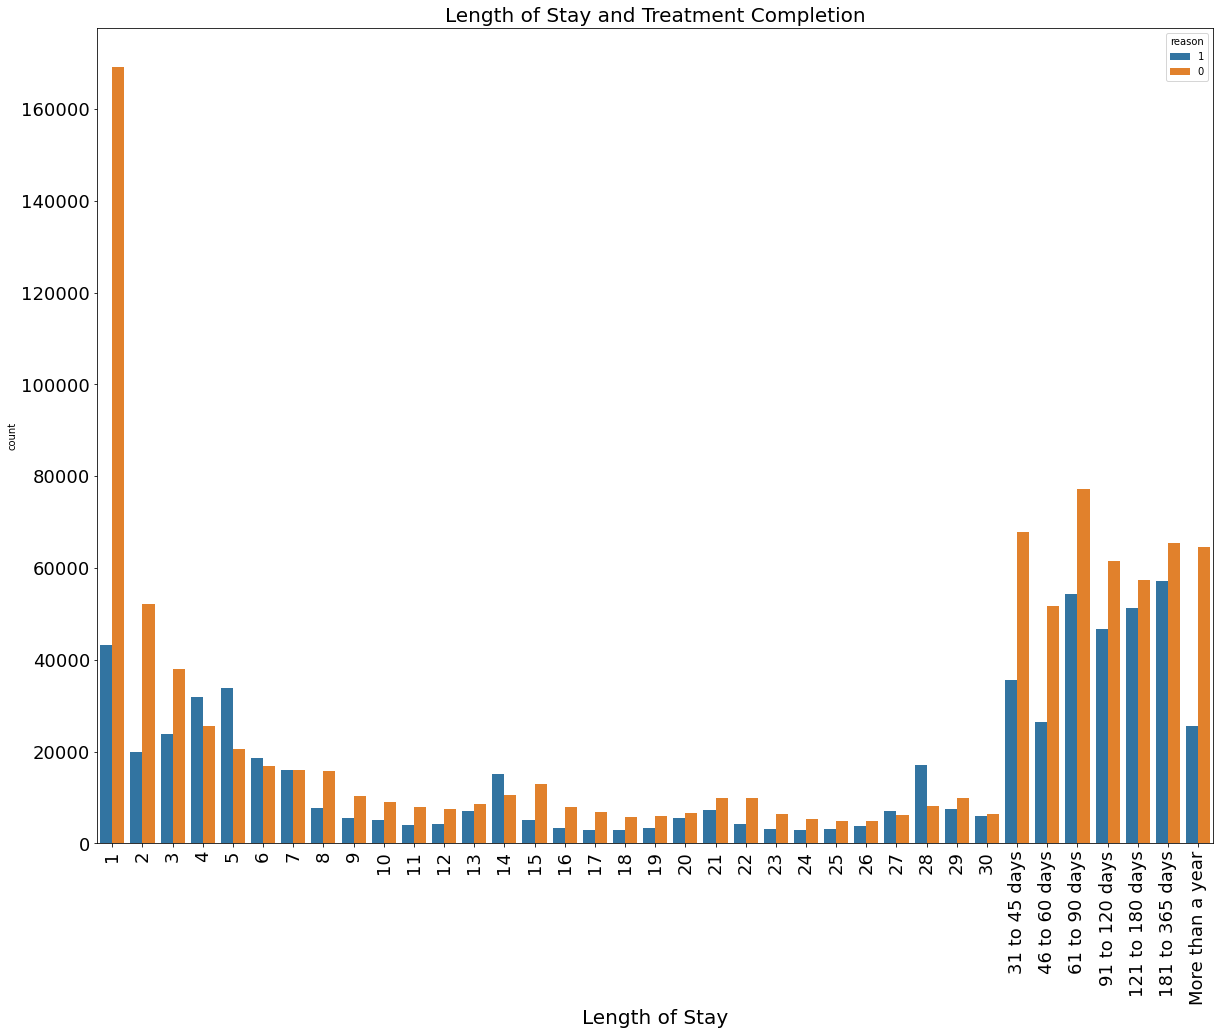

In [31]:
plt.figure(figsize = (20,15))
sns.countplot(data = discharge_complete, x = 'len_stay', 
             hue = 'reason', hue_order = discharge_complete['reason'].unique(),
             order = len_list)
plt.xlabel("Length of Stay", fontdict= {'fontsize': 20})
plt.title("Length of Stay and Treatment Completion", fontdict= {'fontsize': 20})
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(fontsize = 18);


In [32]:
discharge_complete.loc[discharge_complete['len_stay'] == '1',['service']].value_counts(normalize=True)

service                                         
Ambulatory, non-intensive outpatient                0.568317
Detox, 24-hour, free-standing residential           0.185344
Ambulatory, intensive outpatient                    0.165531
Rehab/residential, short term (30 days or fewer)    0.036739
Rehab/residential, long term (more than 30 days)    0.024873
Detox, 24-hour, hospital inpatient                  0.015618
Ambulatory, detoxification                          0.003027
Rehab/residential, hospital (non-detox)             0.000551
dtype: float64

In [33]:
discharge_complete[['service','len_stay']]

,service,len_stay
0,"Ambulatory, non-intensive outpatient",More than a year
1,"Ambulatory, non-intensive outpatient",121 to 180 days
2,"Ambulatory, non-intensive outpatient",121 to 180 days
3,"Ambulatory, non-intensive outpatient",More than a year
4,"Ambulatory, non-intensive outpatient",More than a year
...,...,...
1722498,"Ambulatory, non-intensive outpatient",61 to 90 days
1722499,"Ambulatory, non-intensive outpatient",13
1722500,"Ambulatory, intensive outpatient",61 to 90 days
1722501,"Ambulatory, non-intensive outpatient",14


In [34]:
features = ['diagnosis', 'service', 'len_stay', 'ref_source', ]

In [35]:
(discharge_complete.shape[0] - discharge_complete['diagnosis'].value_counts()[0])/discharge_complete.shape[0]

0.779570436635789

In [36]:
discharge_complete[['diagnosis','substance_1','service','reason'] ]

,diagnosis,substance_1,service,reason
0,Other mental health condition,Alcohol,"Ambulatory, non-intensive outpatient",1
1,Alcohol dependence,Alcohol,"Ambulatory, non-intensive outpatient",0
2,Other mental health condition,Alcohol,"Ambulatory, non-intensive outpatient",0
3,Alcohol dependence,Alcohol,"Ambulatory, non-intensive outpatient",1
4,Alcohol dependence,Alcohol,"Ambulatory, non-intensive outpatient",0
...,...,...,...,...
1722498,Alcohol dependence,Alcohol,"Ambulatory, non-intensive outpatient",0
1722499,Cannabis abuse,Marijuana/hashish,"Ambulatory, non-intensive outpatient",0
1722500,Other substance dependence,Methamphetamine/speed,"Ambulatory, intensive outpatient",0
1722501,Cannabis dependence,Marijuana/hashish,"Ambulatory, non-intensive outpatient",1


In [37]:
pd.DataFrame(discharge_complete['substance_1'].value_counts())

,substance_1
Alcohol,521673
Heroin,391533
Methamphetamine/speed,206912
Marijuana/hashish,187746
Other opiates and synthetics,126346
Cocaine/crack,99141
Benzodiazepines,17802
Other drugs,11766
Other amphetamines,11102
PCP,4193


In [38]:
def count_ploth(data = discharge_complete, y = None, xlab = None, ylab = None, title = None, hue_color = None, figsize = (20,15)):
    plt.figure(figsize = figsize)
    plt.tight_layout
    sns.countplot(data = data, y = y, hue = hue_color, order = discharge_complete[y].value_counts().index)  
    plt.xticks(rotation = 45, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel(xlab, fontdict= {'fontsize': 20})
    plt.ylabel(ylab, fontdict= {'fontsize': 20})
    plt.title(title, fontdict= {'fontsize': 25})
    plt.tight_layout();

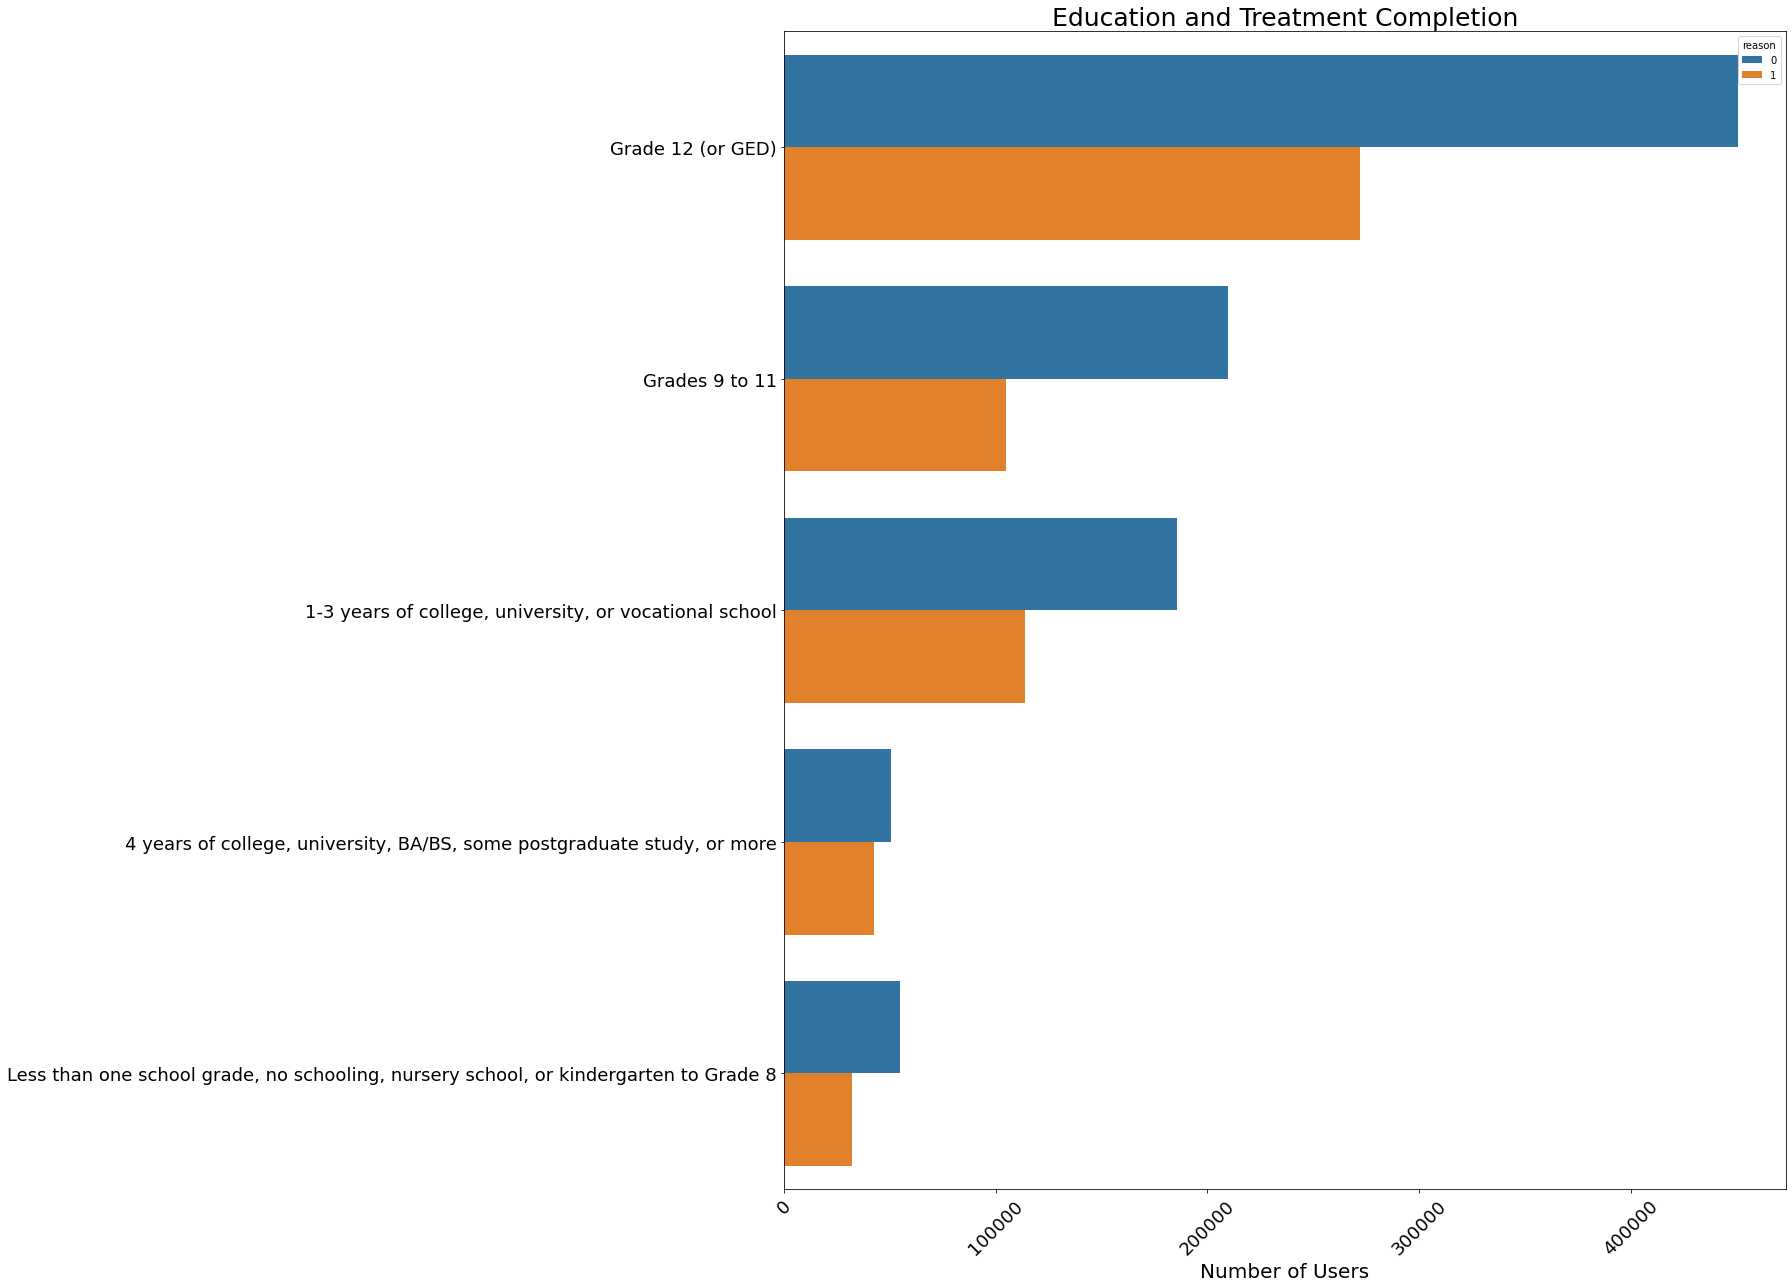

In [39]:
count_ploth(y='education', hue_color = 'reason' , title= "Education and Treatment Completion"
            , xlab='Number of Users', figsize = (25,18))

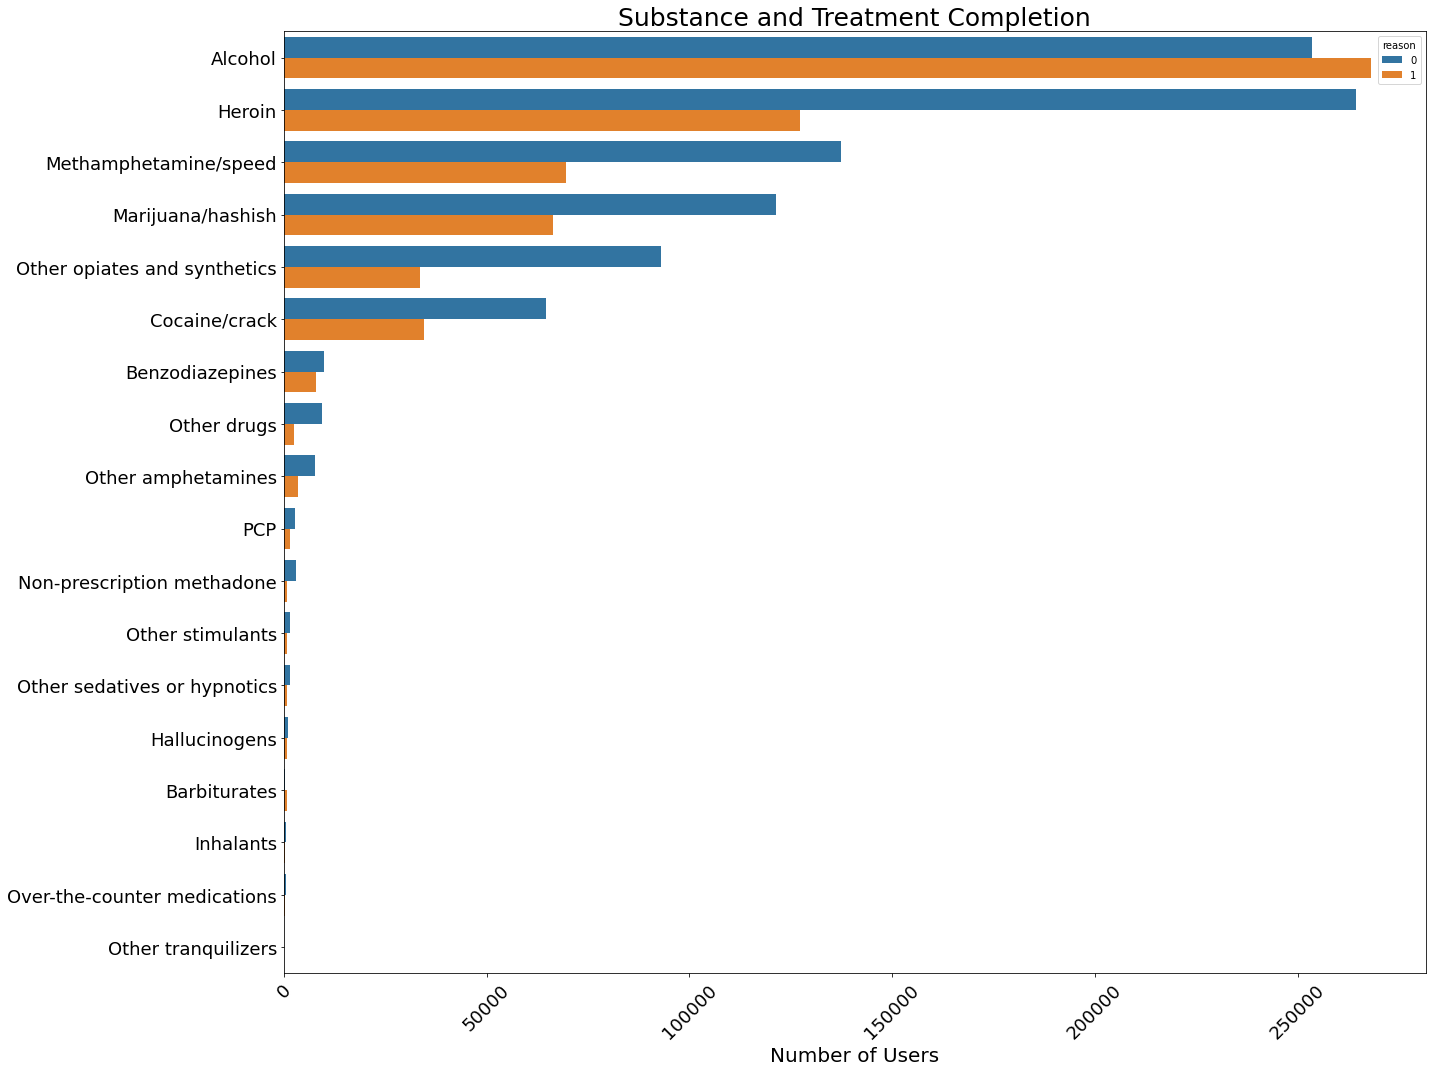

In [40]:
count_ploth(y = 'substance_1', hue_color= 'reason', title = 'Substance and Treatment Completion', 
            xlab= 'Number of Users')

In [41]:
discharge_complete['service'].unique()

array(['Ambulatory, non-intensive outpatient',
       'Ambulatory, intensive outpatient',
       'Detox, 24-hour, free-standing residential',
       'Rehab/residential, long term (more than 30 days)',
       'Rehab/residential, short term (30 days or fewer)',
       'Detox, 24-hour, hospital inpatient',
       'Rehab/residential, hospital (non-detox)',
       'Ambulatory, detoxification'], dtype=object)

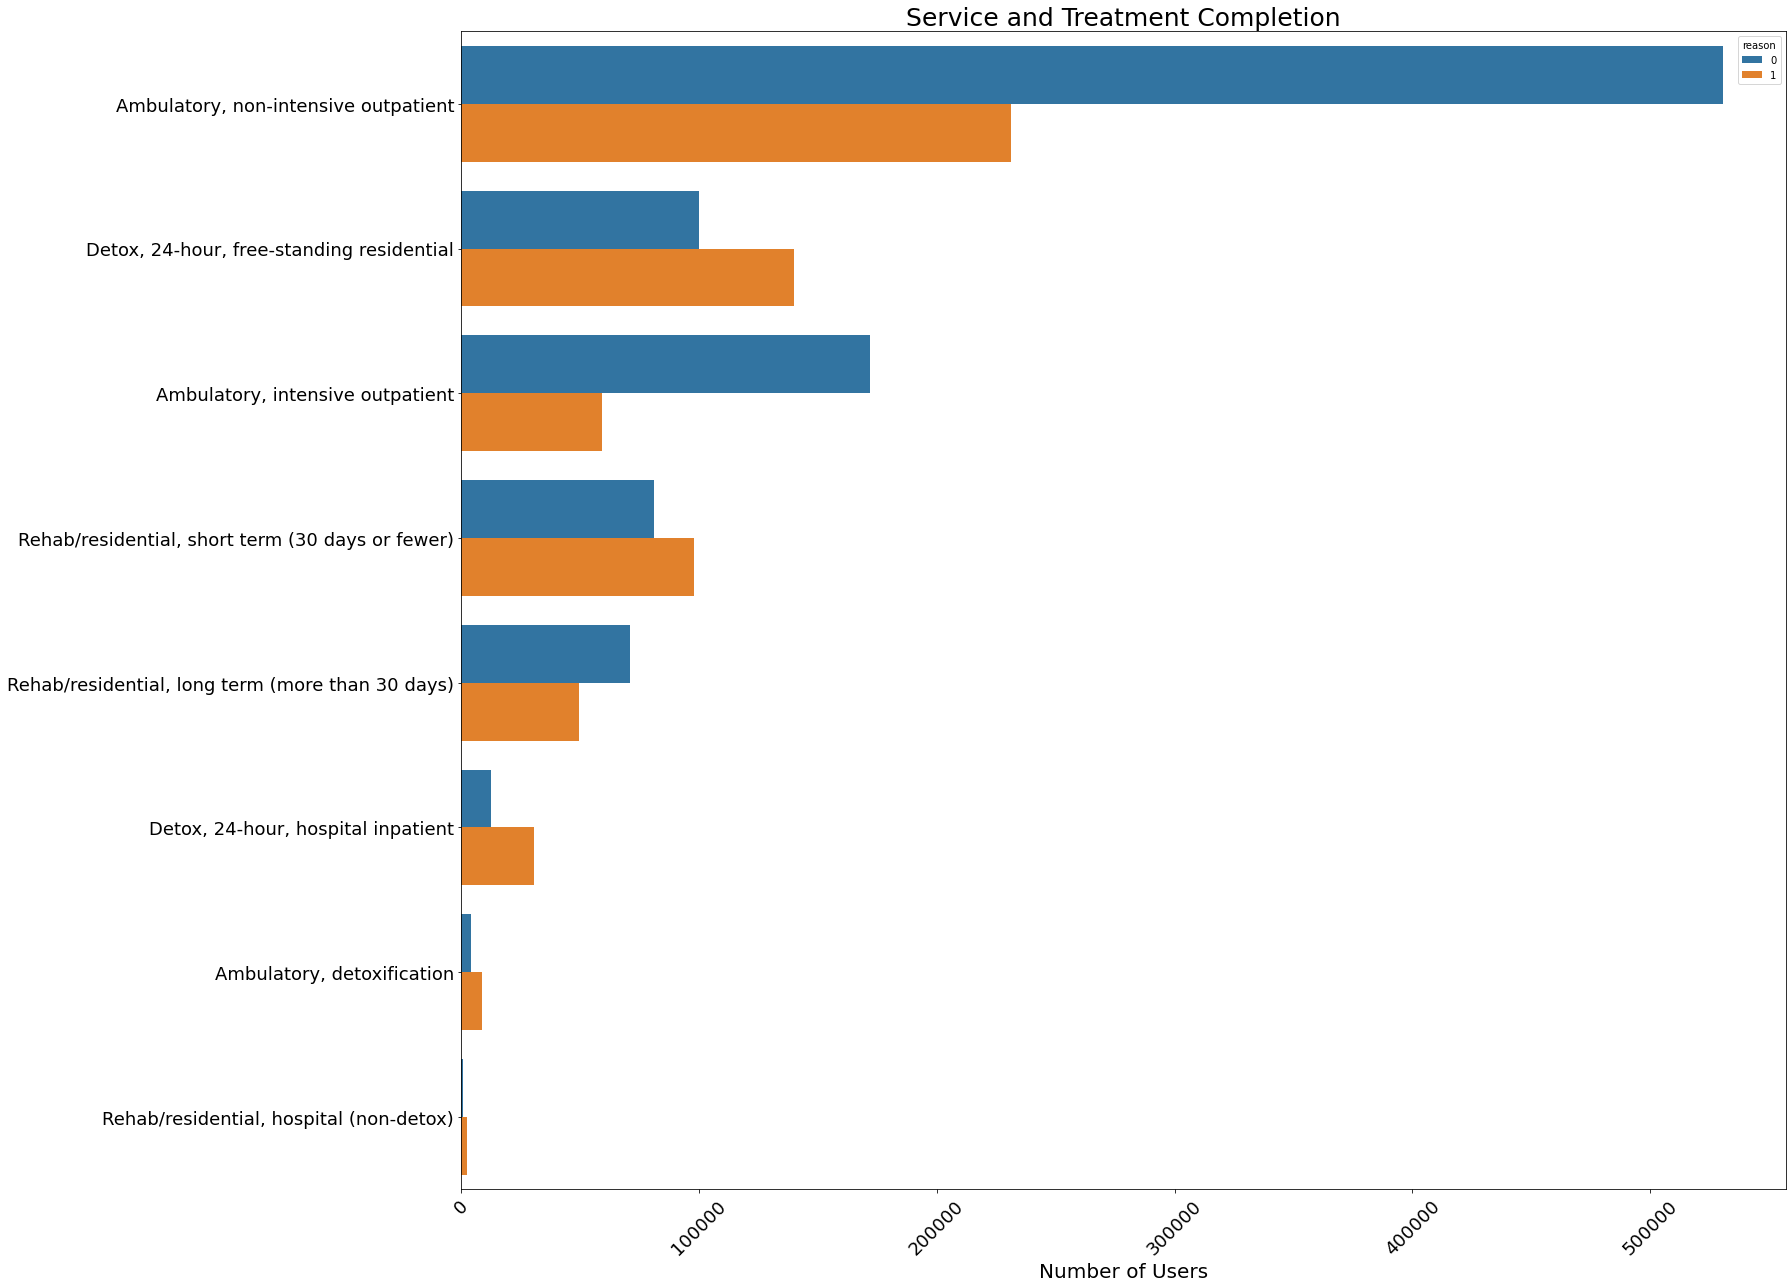

In [42]:
count_ploth(y = 'service', hue_color= 'reason', title = 'Service and Treatment Completion', 
            xlab= 'Number of Users', figsize= (25, 18))

# Feature Selection

In [43]:
discharge_complete.columns.sort_values()

Index(['CASEID', 'MATS', 'afu', 'afu2', 'afu3', 'afu_cat', 'age_range',
       'alc_class', 'alcflg', 'amphflg', 'arrest_cat', 'barbflg', 'benzflg',
       'cen_div', 'co_ment_sub', 'cokeflg', 'crim_ref', 'd_wait', 'diagnosis',
       'edu_cat', 'education', 'empl_status', 'empl_status_D', 'ethnicity',
       'freq', 'freq2', 'freq3', 'freqd', 'freqd2', 'freqd3', 'gender',
       'hallflg', 'herflg', 'housing', 'idu', 'inhflg', 'insurance',
       'len_stay', 'los_cat', 'marflg', 'marital_status', 'methflg',
       'mthhamflg', 'nil_status', 'nil_status_D', 'num_arrest', 'num_arrest_D',
       'opsynflg', 'otcflg', 'otherflg', 'p_income', 'pay_source', 'pcpflg',
       'pregnant', 'prior_cat', 'race', 'reason', 'ref_source', 'region',
       'route2', 'route3', 'sedhpflg', 'self_attend', 'self_attend_d',
       'service', 'service_dis', 'states', 'stimflg', 'sub_route',
       'substance_1', 'substance_1d', 'substance_2', 'substance_2d',
       'substance_3', 'substance_3d', 'treat_ep'

In [44]:
protected = ['pregnant', 'veteran', 'race', 'ethnicity', 'service_dis']

In [45]:
drop = ['alcflg', 'cokeflg', 'marflg', 'herflg',
       'methflg', 'opsynflg', 'pcpflg', 'hallflg', 'mthhamflg', 'amphflg',
       'stimflg', 'benzflg', 'trnqflg', 'barbflg', 'sedhpflg', 'inhflg',
       'otcflg', 'otherflg', 'nil_status', 'nil_status_D','substance_2',
       'substance_3', 'substance_1d', 'substance_2d', 'substance_3d', 'sub_route', 'route2', 'route3', 
       'self_attend_d', 'cen_div', 'region', 'states','crim_ref','num_arrest_D','freq2','freq3', 'freq', 'freq2', 
       'freq3', 'freqd', 'freqd2', 'freqd3','co_ment_sub','empl_status_D','d_wait','afu2', 'afu3','alc_class','insurance',
       'pay_source', 'idu', 'CASEID', 'MATS', 'edu_cat', 'los_cat', 'prior_cat', 'arrest_cat', 'afu_cat']

In [46]:
full_drop = protected + drop

In [47]:
discharge_complete.drop(columns = full_drop, inplace = True)

In [48]:
discharge_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590685 entries, 0 to 1722502
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   education       1516800 non-null  object
 1   marital_status  1296384 non-null  object
 2   service         1590685 non-null  object
 3   len_stay        1590685 non-null  object
 4   ref_source      1562521 non-null  object
 5   treat_ep        1462368 non-null  object
 6   num_arrest      1502843 non-null  object
 7   empl_status     1535769 non-null  object
 8   gender          1589978 non-null  object
 9   housing         1518097 non-null  object
 10  reason          1590685 non-null  int64 
 11  diagnosis       1199503 non-null  object
 12  age_range       1590685 non-null  object
 13  p_income        995494 non-null   object
 14  substance_1     1590685 non-null  object
 15  afu             1571892 non-null  object
 16  self_attend     1361422 non-null  object
dtypes: int64

In [49]:
for col in discharge_complete:
    print(f"""{col}\n
{discharge_complete[col].value_counts(normalize=True)}
    """)

education

Grade 12 (or GED)                                                                       0.476449
Grades 9 to 11                                                                          0.207224
1-3 years of college, university, or vocational school                                  0.197616
4 years of college, university, BA/BS, some postgraduate study, or more                 0.061445
Less than one school grade, no schooling, nursery school, or kindergarten to Grade 8    0.057265
Name: education, dtype: float64
    
marital_status

Never married        0.651211
Divorced, widowed    0.156643
Now married          0.126528
Separated            0.065618
Name: marital_status, dtype: float64
    
service

Ambulatory, non-intensive outpatient                0.478731
Detox, 24-hour, free-standing residential           0.150746
Ambulatory, intensive outpatient                    0.145171
Rehab/residential, short term (30 days or fewer)    0.112411
Rehab/residential, long term (more t

In [50]:
discharge_complete.columns

Index(['education', 'marital_status', 'service', 'len_stay', 'ref_source',
       'treat_ep', 'num_arrest', 'empl_status', 'gender', 'housing', 'reason',
       'diagnosis', 'age_range', 'p_income', 'substance_1', 'afu',
       'self_attend'],
      dtype='object')

In [51]:
#check if categorical variable has a relation to the target variable. No Impute
chi_test_data = []

for col in discharge_complete.drop(columns=['reason']):
    crosstab = pd.crosstab(discharge_complete['reason'], discharge_complete[col], margins=True)
    obs = crosstab.iloc[0:-1, 0:-1] # removes total row/column
    chi2_stat, p_value, d_free, expected  = stats.chi2_contingency(observed=obs)
    crit = stats.chi2.ppf(1-.05, df = d_free) # https://www.statology.org/chi-square-critical-value-python/
    accept_or_reject = chi2_stat > crit
    print(f"""{col}
    critical value = {crit}
    chi2: {chi2_stat}
    p: {p_value}
    Degree of Freedom: {d_free}
    Reject Null: {accept_or_reject}
    """)
    chi_test_data.append([col,crit,chi2_stat,p_value,d_free, accept_or_reject])
#inspiration: https://www.kaggle.com/code/hamelg/python-for-data-25-chi-squared-tests/notebook

education
    critical value = 9.487729036781154
    chi2: 5193.166586436342
    p: 0.0
    Degree of Freedom: 4
    Reject Null: True
    
marital_status
    critical value = 7.814727903251179
    chi2: 471.83296310528294
    p: 6.060739321793761e-102
    Degree of Freedom: 3
    Reject Null: True
    
service
    critical value = 14.067140449340169
    chi2: 122631.58276529417
    p: 0.0
    Degree of Freedom: 7
    Reject Null: True
    
len_stay
    critical value = 50.99846016571065
    chi2: 89817.20544174884
    p: 0.0
    Degree of Freedom: 36
    Reject Null: True
    
ref_source
    critical value = 12.591587243743977
    chi2: 8297.034337363966
    p: 0.0
    Degree of Freedom: 6
    Reject Null: True
    
treat_ep
    critical value = 3.841458820694124
    chi2: 3649.349464346137
    p: 0.0
    Degree of Freedom: 1
    Reject Null: True
    
num_arrest
    critical value = 5.991464547107979
    chi2: 2630.916662520277
    p: 0.0
    Degree of Freedom: 2
    Reject Null: Tru

In [52]:
chi_result_df = pd.DataFrame(chi_test_data, 
                columns = ['features', 'crit_val', 'chi2', 'p_val', 'dof', 'rej_hyp'])

In [53]:
chi_result_df

,features,crit_val,chi2,p_val,dof,rej_hyp
0,education,9.487729,5193.166586,0.000000e+00,4,True
1,marital_status,7.814728,471.832963,6.060739e-102,3,True
2,service,14.067140,122631.582765,0.000000e+00,7,True
3,len_stay,50.998460,89817.205442,0.000000e+00,36,True
4,ref_source,12.591587,8297.034337,0.000000e+00,6,True
5,treat_ep,3.841459,3649.349464,0.000000e+00,1,True
6,num_arrest,5.991465,2630.916663,0.000000e+00,2,True
7,empl_status,7.814728,22103.170202,0.000000e+00,3,True
8,gender,3.841459,6952.459628,0.000000e+00,1,True
9,housing,5.991465,4135.471654,0.000000e+00,2,True


# Evaluation Functions

In [54]:
def classify_score(model = None, X_train = None, X_test = None, y_train = None, y_test = None):
    # Score model on training set.
    print(f'Training Score: {model.score(X_train, y_train)}')

    # Score model on testing set.
    print(f'Testing Score: {model.score(X_test, y_test)}')

In [271]:
def classify_metrics(y_test = None, y_preds= None, title = None):
    
    # Calculates the metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    accuracy = accuracy_score(y_test,y_preds)
    recall = recall_score(y_test,y_preds)
    precision = precision_score(y_test,y_preds)
    specificity = tn/(tn + fp)
    F1score = f1_score(y_test,y_preds)
    roc_auc = roc_auc_score(y_test,y_preds)
    
    # Print Metrics
    print(f"Accuracy Score: {accuracy}")
    print(f"Recall Score: {recall}")
    print(f"Specificity Score: {specificity}")
    print(f"Precision Score: {precision}")
    print(f"F1 Score: {F1score}")
    print(f"ROC AUC Score: {roc_auc}")

    # Lastly create the confusion matrix plots
    fig, ax = plt.subplots(figsize=(10,10))
    plt.rcParams.update({'font.size': 22})
    plt.grid(False)
    ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Blues', normalize='all', ax=ax).ax_.set_title(title)
    #Confusion Matrix set title https://github.com/scikit-learn/scikit-learn/discussions/20690
    #figure size https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
    #Grid line removal https://stackoverflow.com/questions/53574918/how-to-get-rid-of-white-lines-in-confusion-matrix
    # Confusion Matrix Font Size https://stackoverflow.com/questions/67294768/how-can-i-change-the-font-size-in-this-confusion-matrix

# Preprocessing

In [56]:
discharge_complete.columns

Index(['education', 'marital_status', 'service', 'len_stay', 'ref_source',
       'treat_ep', 'num_arrest', 'empl_status', 'gender', 'housing', 'reason',
       'diagnosis', 'age_range', 'p_income', 'substance_1', 'afu',
       'self_attend'],
      dtype='object')

In [57]:
x_drops = ['reason']

In [58]:
X = discharge_complete.drop(columns = x_drops)

In [59]:
X.columns

Index(['education', 'marital_status', 'service', 'len_stay', 'ref_source',
       'treat_ep', 'num_arrest', 'empl_status', 'gender', 'housing',
       'diagnosis', 'age_range', 'p_income', 'substance_1', 'afu',
       'self_attend'],
      dtype='object')

In [60]:
X.shape

(1590685, 16)

In [61]:
y = discharge_complete['reason']

In [62]:
y.value_counts(normalize=True) #Get the baseline accuracy to beat, Imbalanced classes

0    0.610851
1    0.389149
Name: reason, dtype: float64

In [63]:
X.shape,y.shape

((1590685, 16), (1590685,))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30, stratify = y)

In [65]:
X.dtypes

education         object
marital_status    object
service           object
len_stay          object
ref_source        object
treat_ep          object
num_arrest        object
empl_status       object
gender            object
housing           object
diagnosis         object
age_range         object
p_income          object
substance_1       object
afu               object
self_attend       object
dtype: object

In [66]:
X_train.shape

(1193013, 16)

In [67]:
simimp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

In [68]:
X_train_imp = simimp.fit_transform(X_train)

In [69]:
X_test_imp = simimp.transform(X_test)

In [70]:
X_test_imp = pd.DataFrame(X_test_imp, columns = X_train.columns) # change from array to DF

In [71]:
X_test_imp.head()

,education,marital_status,service,len_stay,ref_source,treat_ep,num_arrest,empl_status,gender,housing,diagnosis,age_range,p_income,substance_1,afu,self_attend
0,Grade 12 (or GED),"Divorced, widowed","Ambulatory, intensive outpatient",121 to 180 days,Other health care provider,One or more prior treatment episodes,None,Not in labor force,Female,Independent living,Opioid dependence,25-29 years,Other,Heroin,21-24 years,1-3 times in the past month
1,"Less than one school grade, no schooling, nurs...",Never married,"Ambulatory, intensive outpatient",11,Other community referral,No prior treatment episodes,None,Not in labor force,Female,Dependent living,Opioid dependence,25-29 years,None,Other opiates and synthetics,15-17 years,8-30 times in the past month
2,Grade 12 (or GED),Never married,"Detox, 24-hour, free-standing residential",2,Individual (includes self-referral),One or more prior treatment episodes,None,Unemployed,Female,Dependent living,Opioid dependence,25-29 years,None,Heroin,18-20 years,No attendance
3,Grades 9 to 11,Never married,"Ambulatory, intensive outpatient",1,Individual (includes self-referral),No prior treatment episodes,None,Unemployed,Female,Independent living,Alcohol dependence,21-24 years,None,Alcohol,18-20 years,No attendance
4,Grade 12 (or GED),Never married,"Ambulatory, non-intensive outpatient",121 to 180 days,Court/criminal justice referral/DUI/DWI,No prior treatment episodes,None,Full-time,Female,Independent living,Cannabis dependence,40-44 years,Wages/salary,Marijuana/hashish,15-17 years,No attendance


In [72]:
y_train.value_counts(normalize=True)

0    0.610852
1    0.389148
Name: reason, dtype: float64

In [73]:
os = RandomOverSampler(random_state=30)

In [74]:
X_train_os, y_train_os = os.fit_resample(X_train_imp, y_train)

In [75]:
X_train_os = pd.DataFrame(X_train_os, columns = X_train.columns)

In [76]:
y_train_os.value_counts(normalize=True)

1    0.5
0    0.5
Name: reason, dtype: float64

In [77]:
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'first')

In [78]:
X_train_ohe = ohe.fit_transform(X_train_os)

In [79]:
X_test_ohe = ohe.transform(X_test_imp)

In [237]:
X_train_ohe.shape

(1457508, 125)

# Basic Models

## Logistic Regression Basic

In [80]:
logreg_base = LogisticRegression(max_iter=200, solver='saga', random_state=42)

In [81]:
logreg_base.fit(X_train_ohe, y_train_os)
#35.3s

LogisticRegression(max_iter=200, random_state=42, solver='saga')

In [82]:
classify_score(model = logreg_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.700465451990658
Testing Score: 0.6991716791727857


In [83]:
lbasepreds = logreg_base.predict(X_test_ohe)

Accuracy Score: 0.6991716791727857
Recall Score: 0.7115874226191246
Specificity Score: 0.6912620719749051
Precision Score: 0.5948660051102264
F1 Score: 0.6480126400155353
ROC AUC Score: 0.7014247472970149


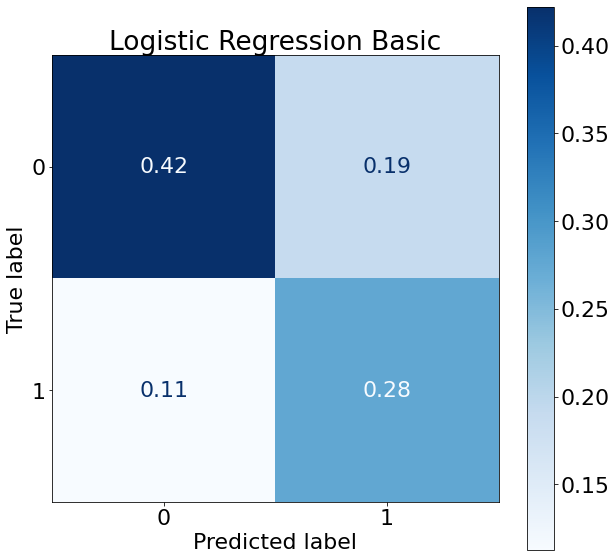

In [272]:
classify_metrics(y_test = y_test, 
                    y_preds = lbasepreds,
                    title="Logistic Regression Basic")

In [85]:
logreg_base.coef_[0]

array([ 0.13093499,  0.20858942, -0.16814848, -0.14626154,  0.24090062,
        0.13787526,  0.06816792, -2.83566057, -2.72515036, -0.55750654,
        0.0816696 , -0.42312466, -1.98002555, -1.23531119,  0.61050402,
        0.55258644,  0.67723804,  1.90988875,  0.95680796,  1.51666575,
        0.59228231,  0.65484224,  0.63453348,  0.83431942,  1.96443598,
        0.82959705, -0.5994033 ,  1.09776769,  1.07377135,  0.83019228,
        0.90618197,  1.00309157,  1.10622646,  1.2633977 ,  1.47448762,
        1.92334516,  1.31333799, -0.19160382,  1.53612792,  1.16257519,
        0.56468252,  1.25166429,  0.93314897,  0.79376194,  1.60026953,
        0.84355851,  0.50046124,  0.54247195,  1.73927969,  1.30690965,
        0.1750938 ,  0.51093125, -0.22828344, -0.00480044, -0.23563429,
        0.23905997,  0.11443429,  0.158936  ,  0.75404794, -0.09545793,
       -0.24705265, -0.29449446,  0.07405525, -0.01959234,  0.14603963,
       -0.62217384,  1.32581355, -0.01618949, -1.14954785, -0.65

In [ ]:
coef_df = pd.DataFrame({'coef': logreg_base.coef_[0]}, index=ohe.get_feature_names_out())
# list(coef_df.index) # Compare to original category list to find dropped column

In [87]:
coef_df.sort_values(by='coef', inplace = True)

In [88]:
top_bottom = [coef_df.head(10), coef_df.tail(10)]
top_bottom_merge = pd.concat(top_bottom)

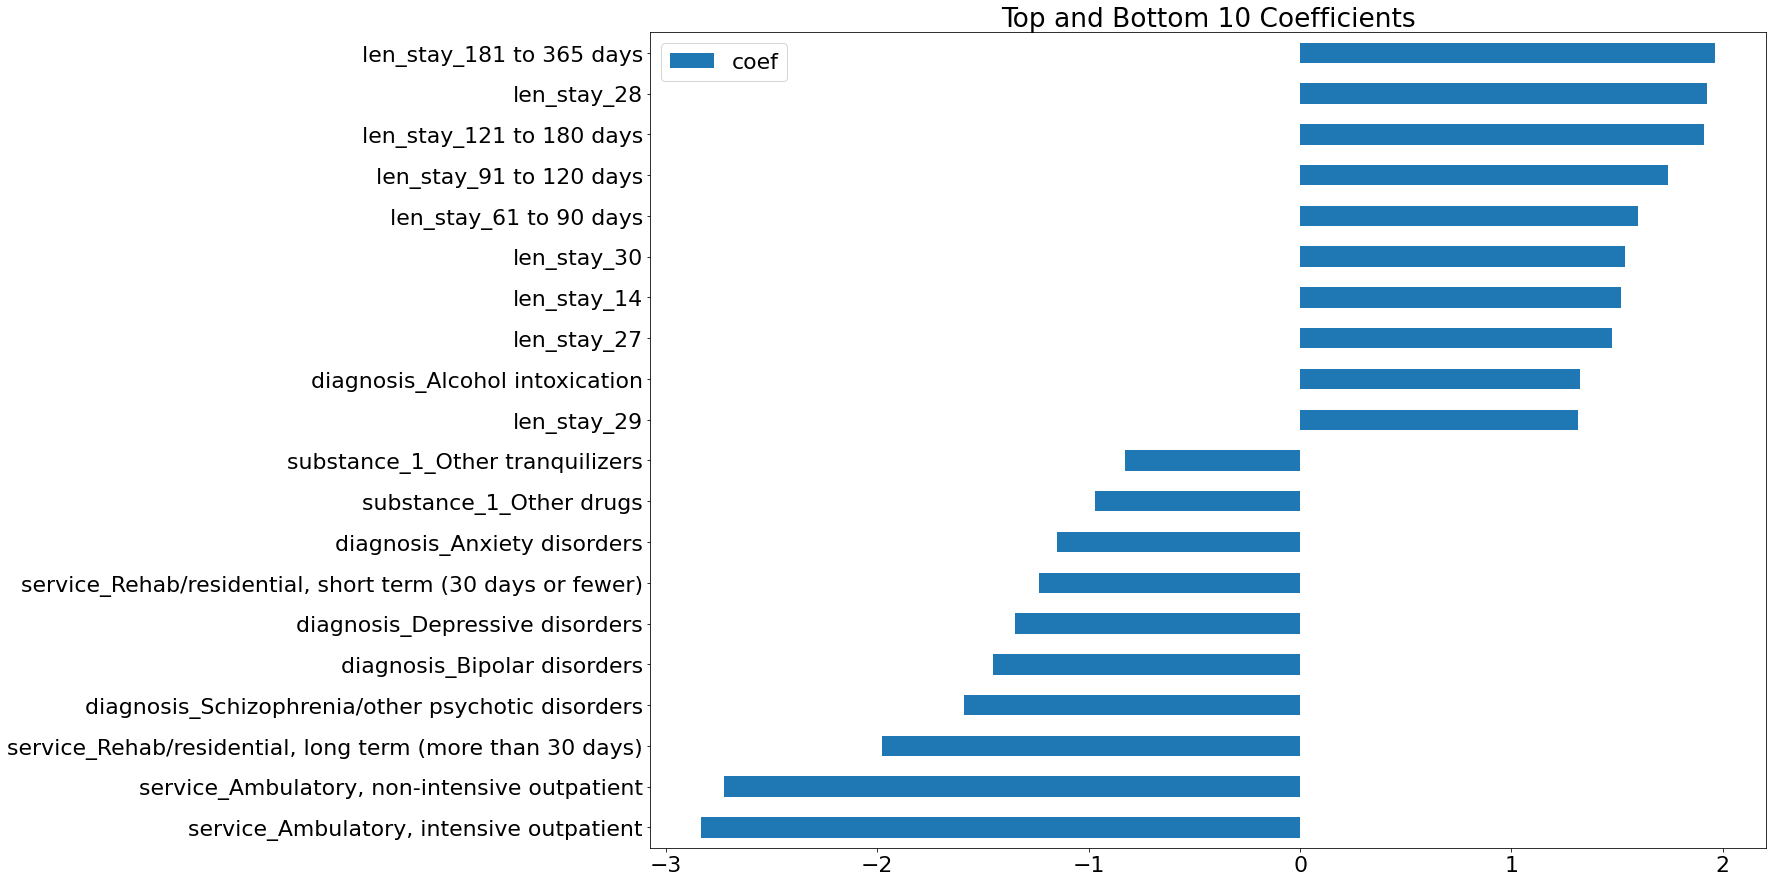

In [89]:
top_bottom_merge.plot(kind = 'barh', figsize = (20,15))
plt.title("Top and Bottom 10 Coefficients");

In [90]:
joblib.dump(logreg_base,'./pklmodels/logreg_base.pkl')

['./pklmodels/logreg_base.pkl']

## Decision Tree

In [91]:
dt_base = DecisionTreeClassifier(random_state=42)

In [92]:
dt_base.fit(X_train_ohe, y_train_os)
#32.6s

DecisionTreeClassifier(random_state=42)

In [93]:
classify_score(model = dt_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.9811863811382168
Testing Score: 0.6911097587961939


In [94]:
dt_base_preds = dt_base.predict(X_test_ohe)

Accuracy Score: 0.6911097587961939
Recall Score: 0.6062460421055352
Specificity Score: 0.7451732683456969
Precision Score: 0.6024813608954477
F1 Score: 0.6043578387953942
ROC AUC Score: 0.675709655225616


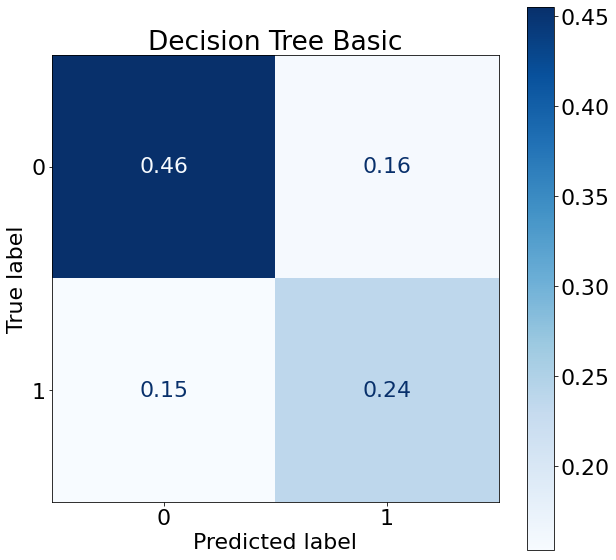

In [273]:
classify_metrics(y_test = y_test, 
                    y_preds = dt_base_preds,
                    title="Decision Tree Basic")

In [96]:
joblib.dump(dt_base,'./pklmodels/dt_base.pkl')

['./pklmodels/dt_base.pkl']

## Random Forest Basic

In [97]:
rf_base = RandomForestClassifier(random_state=42)

In [98]:
rf_base.fit(X_train_ohe, y_train_os)
#5m 22.2s

RandomForestClassifier(random_state=42)

In [99]:
classify_score(model = rf_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.9811808923175722
Testing Score: 0.7481341406988674


In [100]:
rf_base_preds = rf_base.predict(X_test_ohe)

Accuracy Score: 0.7481341406988674
Recall Score: 0.6509750959587475
Specificity Score: 0.8100305452868869
Precision Score: 0.6858354664778606
F1 Score: 0.6679507495640528
ROC AUC Score: 0.7305028206228171


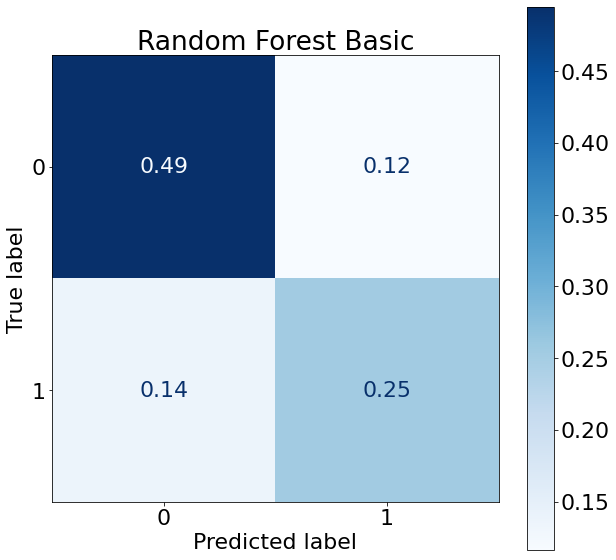

In [274]:
classify_metrics(y_test = y_test, 
                    y_preds = rf_base_preds,
                    title="Random Forest Basic")

In [140]:
rf_base.feature_importances_

array([8.62840928e-03, 2.52621088e-02, 1.43673421e-02, 8.06087664e-03,
       2.03585829e-02, 1.15006737e-02, 7.82385484e-03, 1.68660830e-02,
       2.66728023e-02, 1.78673216e-02, 7.28501145e-03, 9.70468425e-04,
       6.82057409e-03, 1.20950120e-02, 2.78009147e-03, 2.41608480e-03,
       2.30311283e-03, 1.26445752e-02, 2.67499621e-03, 4.16657439e-03,
       3.15523972e-03, 2.15558908e-03, 1.97393848e-03, 1.83716472e-03,
       1.43303108e-02, 1.80933896e-03, 1.20099690e-02, 2.40407037e-03,
       2.95165544e-03, 2.59860802e-03, 1.90390422e-03, 1.76636647e-03,
       1.71171066e-03, 1.91444786e-03, 2.55221479e-03, 5.37114505e-03,
       3.42507875e-03, 7.52642055e-03, 2.80378163e-03, 9.80951027e-03,
       6.76016972e-03, 8.71680119e-03, 7.46748989e-03, 5.57186638e-03,
       1.24806012e-02, 5.28649353e-03, 4.27017208e-03, 3.21350398e-03,
       1.19476929e-02, 9.47521492e-03, 1.51686436e-02, 1.24405539e-03,
       1.73053718e-02, 9.91789677e-03, 8.40788352e-03, 8.87830525e-04,
      

In [102]:
joblib.dump(rf_base,'./pklmodels/rf_base.pkl')

['./pklmodels/rf_base.pkl']

## Bernoulli NB Basic

In [103]:
bernb_base = BernoulliNB()

In [104]:
bernb_base.fit(X_train_ohe, y_train_os)
#1.8s

BernoulliNB()

In [105]:
classify_score(model = bernb_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.6491744813750594
Testing Score: 0.6591261139833833


In [106]:
bernb_base_preds = bernb_base.predict(X_test_ohe)

Accuracy Score: 0.6591261139833833
Recall Score: 0.6073122504103287
Specificity Score: 0.6921347944573889
Precision Score: 0.5568762220773834
F1 Score: 0.5810017185742017
ROC AUC Score: 0.6497235224338589


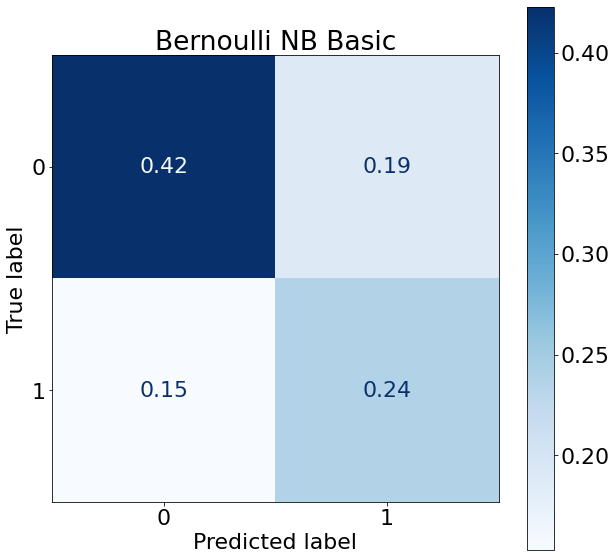

In [275]:
classify_metrics(y_test = y_test, 
                    y_preds = bernb_base_preds,
                    title="Bernoulli NB Basic")

In [108]:
joblib.dump(bernb_base,'./pklmodels/bernb_base.pkl')

['./pklmodels/bernb_base.pkl']

## Xgboost Basic

In [109]:
xgb_base = XGBClassifier(use_label_encoder=False , seed = 42, 
                        objective = 'binary:logistic',
                        tree_method = 'gpu_hist')

#https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
# might want to use terminal in hindsight

In [110]:
xgb_base.fit(X_train_ohe, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [111]:
classify_score(model = xgb_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.7356110566803064
Testing Score: 0.732842644189181


In [112]:
xgb_base_preds = xgb_base.predict(X_test_ohe)

Accuracy Score: 0.732842644189181
Recall Score: 0.7337257841477441
Specificity Score: 0.7322800286516438
Precision Score: 0.6358291195591916
F1 Score: 0.6812785936070319
ROC AUC Score: 0.733002906399694


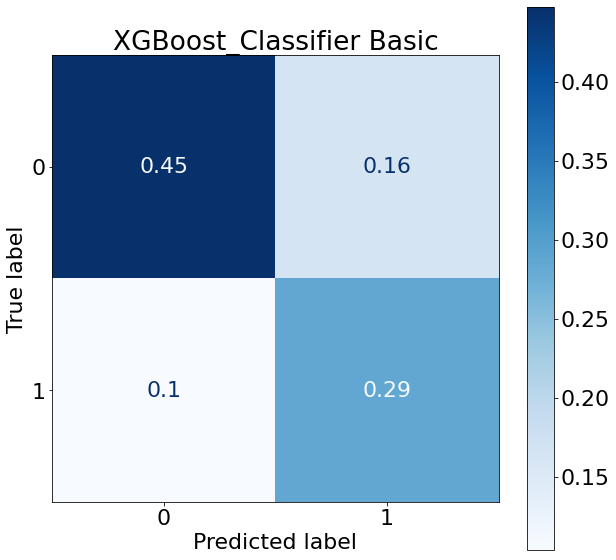

In [276]:
classify_metrics(y_test = y_test, 
                    y_preds = xgb_base_preds, title= 'XGBoost_Classifier Basic')

In [114]:
joblib.dump(xgb_base,'./pklmodels/xgb_base.pkl')

['./pklmodels/xgb_base.pkl']

## KNN Basic

In [205]:
knn_base = KNeighborsClassifier()

In [206]:
knn_base.fit(X_train_ohe, y_train_os)
#0.2s

KNeighborsClassifier()

In [207]:
classify_score(model = knn_base, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

#Over 15 hours

Training Score: 0.8231035438570492
Testing Score: 0.6868122472791648


In [208]:
knn_base_preds = knn_base.predict(X_test_ohe)

Accuracy Score: 0.6868122472791648
Recall Score: 0.6764865528516226
Specificity Score: 0.6933903621798302
Precision Score: 0.5842998269799632
F1 Score: 0.6270229153939221
ROC AUC Score: 0.6849384575157265


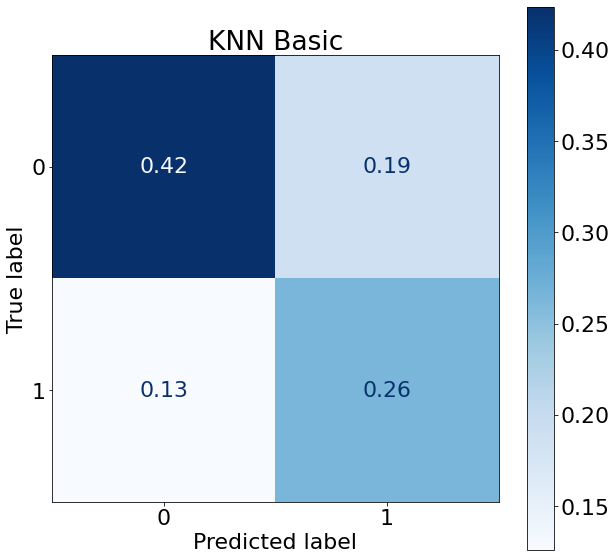

In [277]:
classify_metrics(y_test = y_test, 
                    y_preds = knn_base_preds, title= 'KNN Basic')

In [210]:
joblib.dump(knn_base,'./pklmodels/knn_base.pkl')

['./pklmodels/knn_base.pkl']

# Hyperparameter Tuned

## Random Forest

In [227]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

rf_params = {
    'rf__n_estimators': [100],
    'rf__min_samples_leaf': [1],
    'rf__min_samples_split': [2],
    'rf__max_depth': [40]
    }

rf_gs = GridSearchCV(rf_pipe,
            param_grid = rf_params,
            cv = 5,
            verbose = 3,
            n_jobs = -2)

rf_gs.fit(X_train_ohe,y_train_os)

# add bias, min sample per leaf
# min max depth
# Optuna library in hindsight
# Threshholds percentage
# predict proba

%time

# train: .96
# test:  .75
# prec:  .68

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 0 ns
Wall time: 0 ns


In [262]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

rf_params = {
    'rf__n_estimators': [200],
    'rf__min_samples_leaf': [2],
    'rf__min_samples_split': [3]
    }

rf_gs = GridSearchCV(rf_pipe,
            param_grid = rf_params,
            cv = 5,
            verbose = 3,
            n_jobs = -2)

rf_gs.fit(X_train_ohe,y_train_os)

# add bias, min sample per leaf
# min max depth
# Optuna library in hindsight
# Threshholds percentage
# predict proba

%time

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 0 ns
Wall time: 8.06 ms


In [263]:
rf_gs.best_params_

{'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 200}

In [264]:
classify_score(model = rf_gs, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)

Training Score: 0.8935717677021326
Testing Score: 0.7576017421392505


In [265]:
rf_gs_preds = rf_gs.predict(X_test_ohe)

Accuracy Score: 0.7576017421392505
Recall Score: 0.7008671827545653
Specificity Score: 0.7937452144345005
Precision Score: 0.6840223252294012
F1 Score: 0.6923423092758498
ROC AUC Score: 0.747306198594533


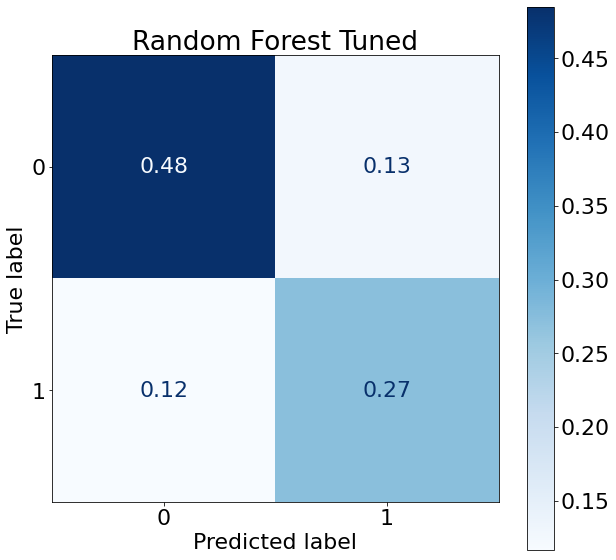

In [279]:
classify_metrics(y_test, 
                    y_preds = rf_gs_preds, 
                    title = "Random Forest Tuned")

In [183]:
joblib.dump(rf_gs,'./pklmodels/rf_gs.pkl')

['./pklmodels/rf_gs.pkl']

## XGBoost

In [257]:
xgb_pipe = Pipeline([
    ('xgb', XGBClassifier())
])

xgb_params = {
    'xgb__use_label_encoder':[False],
    'xgb__seed': [42],
    'xgb__objective': ['binary:logistic'],
    'xgb__eval_metric': ['auc'],
    'xgb__tree_method': ['gpu_hist'],
    'xgb__max_depth': [25], # Higher = more complex
    'xgb__learning_rate': [0.1], # Rule of thumb lower is better
    'xgb__subsample' : [.5], # .5 to prevent overfitting
    'xgb__n_estimators': [200], # Number of Trees
    'xgb__min_child_weight': [4,5,6]
}

xgb_gs = GridSearchCV(xgb_pipe,
            param_grid = xgb_params,
            cv = 5,
            verbose = 3)
# source: https://www.youtube.com/watch?v=ap2SS0-XPcE&t=987s&ab_channel=HarshKumar
# source: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

xgb_gs.fit(X_train_ohe,y_train_os)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END xgb__eval_metric=auc, xgb__learning_rate=0.1, xgb__max_depth=25, xgb__min_child_weight=4, xgb__n_estimators=200, xgb__objective=binary:logistic, xgb__seed=42, xgb__subsample=0.5, xgb__tree_method=gpu_hist, xgb__use_label_encoder=False;, score=0.772 total time= 4.2min
[CV 2/5] END xgb__eval_metric=auc, xgb__learning_rate=0.1, xgb__max_depth=25, xgb__min_child_weight=4, xgb__n_estimators=200, xgb__objective=binary:logistic, xgb__seed=42, xgb__subsample=0.5, xgb__tree_method=gpu_hist, xgb__use_label_encoder=False;, score=0.773 total time= 4.3min
[CV 3/5] END xgb__eval_metric=auc, xgb__learning_rate=0.1, xgb__max_depth=25, xgb__min_child_weight=4, xgb__n_estimators=200, xgb__objective=binary:logistic, xgb__seed=42, xgb__subsample=0.5, xgb__tree_method=gpu_hist, xgb__use_label_encoder=False;, score=0.774 total time= 4.3min
[CV 4/5] END xgb__eval_metric=auc, xgb__learning_rate=0.1, xgb__max_depth=25, xgb__min_child_weig

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                

In [258]:
xgb_gs.best_params_

# T1
# {'xgb__eval_metric': 'auc',
#  'xgb__learning_rate': 0.7,
#  'xgb__max_depth': 8,
#  'xgb__n_estimators': 100,
#  'xgb__objective': 'binary:logistic',
#  'xgb__seed': 42,
#  'xgb__tree_method': 'gpu_hist',
#  'xgb__use_label_encoder': False}

# # T2
# {'xgb__eval_metric': 'auc',
#  'xgb__learning_rate': 0.7,
#  'xgb__max_depth': 10,
#  'xgb__n_estimators': 200,
#  'xgb__objective': 'binary:logistic',
#  'xgb__seed': 42,
#  'xgb__subsample': 1,
#  'xgb__tree_method': 'gpu_hist',
#  'xgb__use_label_encoder': False}

# T3
# {'xgb__eval_metric': 'auc',
#  'xgb__learning_rate': 0.7,
#  'xgb__max_depth': 10,
#  'xgb__min_child_weight': 5,
#  'xgb__n_estimators': 200,
#  'xgb__objective': 'binary:logistic',
#  'xgb__seed': 42,
#  'xgb__subsample': 0.5,
#  'xgb__tree_method': 'gpu_hist',
#  'xgb__use_label_encoder': False}

# T4
# {'xgb__eval_metric': 'auc',
#  'xgb__learning_rate': 0.1,
#  'xgb__max_depth': 25,
#  'xgb__n_estimators': 200,
#  'xgb__objective': 'binary:logistic',
#  'xgb__seed': 42,
#  'xgb__subsample': 0.5,
#  'xgb__tree_method': 'gpu_hist',
#  'xgb__use_label_encoder': False}

{'xgb__eval_metric': 'auc',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 25,
 'xgb__min_child_weight': 4,
 'xgb__n_estimators': 200,
 'xgb__objective': 'binary:logistic',
 'xgb__seed': 42,
 'xgb__subsample': 0.5,
 'xgb__tree_method': 'gpu_hist',
 'xgb__use_label_encoder': False}

In [259]:
classify_score(model = xgb_gs, 
                X_train = X_train_ohe, 
                X_test = X_test_ohe, 
                y_test = y_test, 
                y_train = y_train_os)
# T1  
# Training Score: 0.7642777947016415
# Testing Score: 0.7454711420467118

# T2
# Training Score: 0.8185457644143291
# Testing Score: 0.7451266370275

# T3
# Training Score: 0.7865747563649736
# Testing Score: 0.7395164859482186

# T4
# Training Score: 0.9258144723733935
# Testing Score: 0.7527007181798064

Training Score: 0.8713207749116986
Testing Score: 0.7546797360638918


In [260]:
xgb_gs_preds = xgb_gs.predict(X_test_ohe)

Accuracy Score: 0.7546797360638918
Recall Score: 0.7156325523088256
Specificity Score: 0.779555240863172
Precision Score: 0.6740658685185974
F1 Score: 0.6942275686332279
ROC AUC Score: 0.7475938965859988


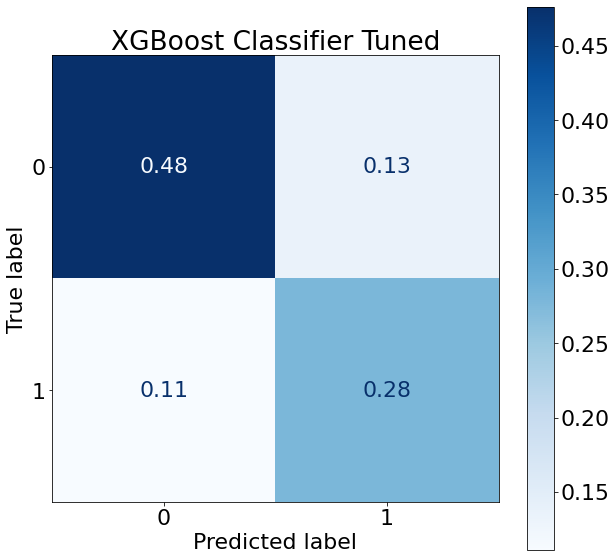

In [280]:
classify_metrics(y_test = y_test, 
                    y_preds = xgb_gs_preds, title= 'XGBoost Classifier Tuned')
# T1
# Accuracy Score: 0.7454711420467118
# Recall Score: 0.7389857451180584
# Specificity Score: 0.7496027466058506
# Precision Score: 0.6527938716913926
# F1 Score: 0.6932209091928557
# ROC AUC Score: 0.7442942458619545

# T2
# Accuracy Score: 0.7451266370275
# Recall Score: 0.7226953745945177
# Specificity Score: 0.7594167579183099
# Precision Score: 0.6567928495084624
# F1 Score: 0.6881699257928352
# ROC AUC Score: 0.7410560662564138

# T3
# Accuracy Score: 0.7395164859482186
# Recall Score: 0.7205888054589865
# Specificity Score: 0.751574605422406
# Precision Score: 0.6488615799977889
# F1 Score: 0.6828467767861244
# ROC AUC Score: 0.7360817054406962


# T4
# Accuracy Score: 0.7527007181798064
# Recall Score: 0.6931775592230249
# Specificity Score: 0.7906207032825892
# Precision Score: 0.6783613897074633
# F1 Score: 0.6856894479813864
# ROC AUC Score: 0.741899131252807

In [135]:
joblib.dump(xgb_gs,'./pklmodels/xgb_gs.pkl')

['./pklmodels/xgb_gs.pkl']